# Libraries

In [40]:
# Data set 
from tensorflow.keras.datasets import mnist
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Logistic Regression
import numpy as np
from sklearn.linear_model import LogisticRegression
# Tenser Flow  for RMS Promp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
# Accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# hyper parameters tunng 
from kerastuner import RandomSearch, HyperParameters
import kerastuner as kt
from keras.optimizers import Adam


# Load MNIST Data set 

Before normalization:
Max pixel value: 255
Min pixel value: 0


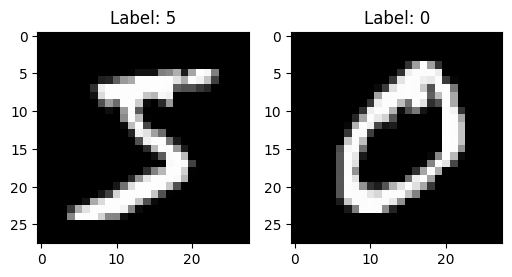

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("Before normalization:")
print("Max pixel value:", train_images.max())
print("Min pixel value:", train_images.min())
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.subplot(1, 2, 2)
plt.imshow(train_images[1], cmap='gray')
plt.title(f"Label: {train_labels[1]}")

plt.show()

# -----------------------------Pre PRocessing------------------------------

### Normalization


After normalization:
Max pixel value: 1.0
Min pixel value: 0.0


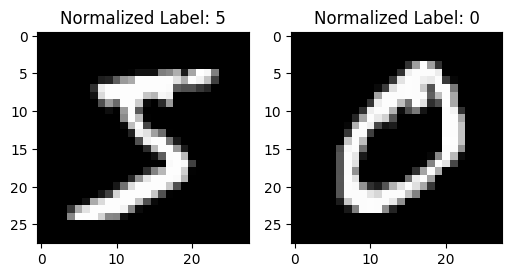

In [3]:

train_images_normalized = train_images.astype('float32') / 255.0
test_images_normalized = test_images.astype('float32') / 255.0
print("\nAfter normalization:")
print("Max pixel value:", train_images_normalized.max())
print("Min pixel value:", train_images_normalized.min())
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(train_images_normalized[0], cmap='gray')
plt.title(f"Normalized Label: {train_labels[0]}")

plt.subplot(1, 2, 2)
plt.imshow(train_images_normalized[1], cmap='gray')
plt.title(f"Normalized Label: {train_labels[1]}")

plt.show()

### StandardScaler

Train images mean (after standardization): -4.987327217875759e-10
Train images std (after standardization): 0.9563164114952087


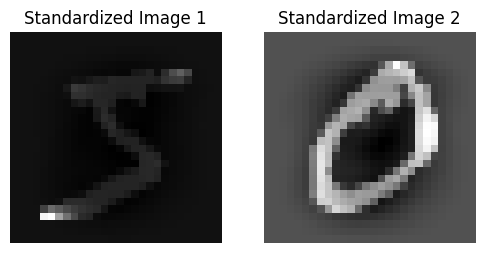

In [4]:
scaler = StandardScaler()
train_images_reshaped = train_images_normalized.reshape((train_images.shape[0], -1))
test_images_reshaped = test_images_normalized.reshape((test_images.shape[0], -1))
train_images_standardized = scaler.fit_transform(train_images_reshaped)
test_images_standardized = scaler.transform(test_images_reshaped)
print(f"Train images mean (after standardization): {train_images_standardized.mean()}")
print(f"Train images std (after standardization): {train_images_standardized.std()}")
standardized_image_1 = train_images_standardized[0].reshape(28, 28)
standardized_image_2 = train_images_standardized[1].reshape(28, 28)

plt.figure(figsize=(6, 3))
for i, img in enumerate([standardized_image_1, standardized_image_2]):
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Standardized Image {i+1}")
    plt.axis('off')
plt.show()

### PCA

In [5]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance
preprosess_train_images = pca.fit_transform(train_images_standardized)
preprocess_test_images = pca.transform(test_images_standardized)
print(f"Original number of features: {train_images_standardized.shape[1]}")
print(f"Reduced number of features after PCA (train): {preprosess_train_images.shape[1]}")
print(f"Reduced number of features after PCA (test): {preprocess_test_images.shape[1]}")


# Ensure the number of samples in train and test sets are consistent with labels
if preprosess_train_images.shape[0] != train_labels.shape[0]:
    raise ValueError(f"Training images PCA shape mismatch: {preprosess_train_images.shape[0]} vs {train_labels.shape[0]}")

if preprocess_test_images.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Test images PCA shape mismatch: {preprocess_test_images.shape[0]} vs {test_labels.shape[0]}")

Original number of features: 784
Reduced number of features after PCA (train): 331
Reduced number of features after PCA (test): 331


# Build Model to chek and find best hyper perameter

In [38]:
def build_model(hp, input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    num_layers = hp.Int('num_layers', 1, 5)  
    for i in range(num_layers):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
        dropout_rate = hp.Float(f'dropout_rate_{i}', 0, 0.5, step=0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=models.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [49]:
def tune_hyperparameters(preprosess_train_images, train_labels):
    split_index = int(len(preprosess_train_images) * 0.8)
    train_images_hp, val_images_hp = preprosess_train_images[:split_index], preprosess_train_images[split_index:]
    train_labels_hp, val_labels_hp = train_labels[:split_index], train_labels[split_index:]

    tuner = kt.Hyperband(
        lambda hp: build_model(hp, preprosess_train_images.shape[1:]),  
        objective='val_accuracy',
        max_epochs=50,
        hyperband_iterations=2,
        directory='my_dir_NN',  
        project_name='hyperparameter_tuning_NN'
    )
    tuner.search(train_images_hp, train_labels_hp, 
                 epochs=10,
                 validation_data=(val_images_hp, val_labels_hp),
                 batch_size=16) 

    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_params = {
        'learning_rate': best_hyperparameters.get('learning_rate'),
        'num_layers': best_hyperparameters.get('num_layers'),
        'units': [best_hyperparameters.get(f'units_{i}') for i in range(best_hyperparameters.get('num_layers'))],
        'dropout_rates': [best_hyperparameters.get(f'dropout_rate_{i}') for i in range(best_hyperparameters.get('num_layers'))],
    }

    return best_params


In [51]:
input_shape = preprosess_train_images.shape[1:]
best_params = tune_hyperparameters(preprosess_train_images, train_labels)
best_params 

Reloading Tuner from my_dir_NN\hyperparameter_tuning_NN\tuner0.json


{'learning_rate': 0.00021183086516208134,
 'num_layers': 2,
 'units': [224, 224],
 'dropout_rates': [0.4, 0.1]}

# Test The model With Hyper Perameter

In [52]:
def train_neural_network(train_images, train_labels, num_layers, units, dropout_rates, learning_rate, batch_size=None, epochs=10):
    if batch_size is None:
        batch_size = 16
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=train_images.shape[1:]))
    for i in range(num_layers):
        model.add(layers.Dense(units[i], activation='relu'))
        model.add(layers.Dropout(dropout_rates[i]))

    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)
    
    return model


In [54]:
model = train_neural_network(preprosess_train_images,train_labels,num_layers=best_params['num_layers'],units=best_params['units'],dropout_rates=best_params['dropout_rates'],learning_rate=best_params['learning_rate'],epochs=100  )

Epoch 1/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.7372 - loss: 0.8762
Epoch 2/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9180 - loss: 0.2856
Epoch 3/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9379 - loss: 0.2094
Epoch 4/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9473 - loss: 0.1735
Epoch 5/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9576 - loss: 0.1397
Epoch 6/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9605 - loss: 0.1301
Epoch 7/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9651 - loss: 0.1131
Epoch 8/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9685 - loss: 0.1056
Epoch 9/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9708 - loss: 0.0940
Epoch 10/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9718 - loss: 0.0930
Epoch 11/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9744 - loss: 0.0809
Epo

# Evalute THe results

In [55]:
def evaluate_log_reg(model, test_images, test_labels, use_tensorflow=False):
    if use_tensorflow:
        probabilities = model.predict(test_images)
        predictions = np.argmax(probabilities, axis=1)  
    else:
        predictions = model.predict(test_images)  

    # Evaluate the model
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')

    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Model Precision: {precision:.4f}")
    print(f"Model Recall: {recall:.4f}")
    print(f"Model F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions))

    # Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Visualize class separation in PCA space
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(test_images[:, 0], test_images[:, 1], c=predictions, cmap='viridis', alpha=0.5)
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.title("PCA of Test Dataset with Logistic Regression Predictions")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, label='Predicted Classes')
    plt.show()

    # Additional visualizations
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    
    plt.figure(figsize=(10, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.show()

    return accuracy, predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model Accuracy: 0.9808
Model Precision: 0.9808
Model Recall: 0.9808
Model F1 Score: 0.9808

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



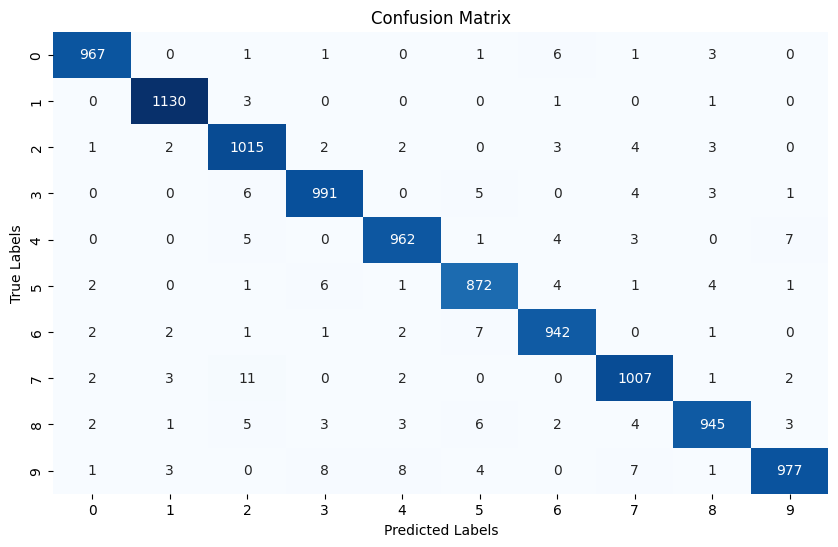

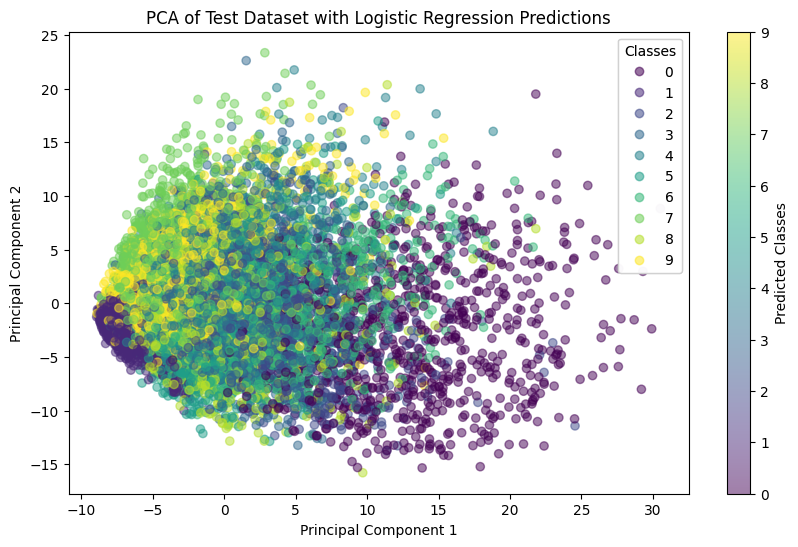

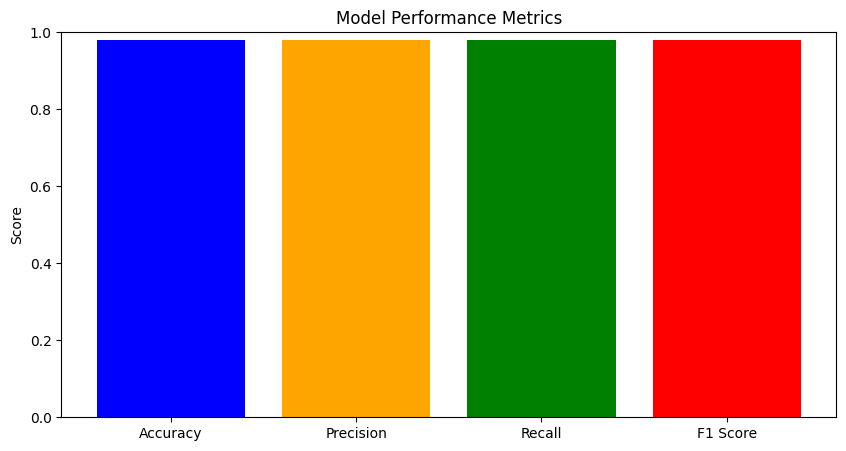

(0.9808, array([7, 2, 1, ..., 4, 5, 6], dtype=int64))

In [56]:
evaluate_log_reg(model,preprocess_test_images, test_labels, use_tensorflow=True)